# Análisis con DNase-seq y RNA-seq con Pyntegrate

En este ejemplo se va a ver como realizar un análisis de DNase-seq para posteriormente juntarlo con RNA-seq.

Lo primero que se ha de hacer es importan las librerías que van a ser necesarias.

In [1]:
import os
import Pyntegrate
import matplotlib.pyplot as plt
import numpy as np

Una vez se tienen las librerías, se va a ejecutar una función que tiene el sigueinte funcionamiento:
Se van a calcular los intervalos de las transcripciones (tsses) y posteriromente se van a extender estas trasncripcions 1000 bases (tsses_1kb)
Una vez se tienen estos archivos de transcripciones, se procede a cargar los valores de las señal de DNase-seq y se guardarán estos valores en la variable atac_signal.
Es importante indicar el genoma con el que operar(en mi caso es mm10 al estar usando datos de ratón)

In [3]:
bins = 100

features, atac_signal, tsses,tsses_1kb = Pyntegrate.SeqSignalAnalysis.generate_array_simple_signal(dbPath='/home/jerry/Documentos/Python3.10/prueba/data/gencode.vM25.annotation.gtf.db',
                                                                                                   filePath='/home/jerry/Documentos/Python3.10/prueba/mosimData/test_2_DNase-seq.bw',
                                                                                                   extensionFile='bigwig',
                                                                                                   genome='mm10',
                                                                                                   bins=bins)

Una vez se tienen los valores de la señal de DNase-seq, se procede a generar los mapas de calor para poder analizar los valores de esta señal respecto a la distancia del TSS.

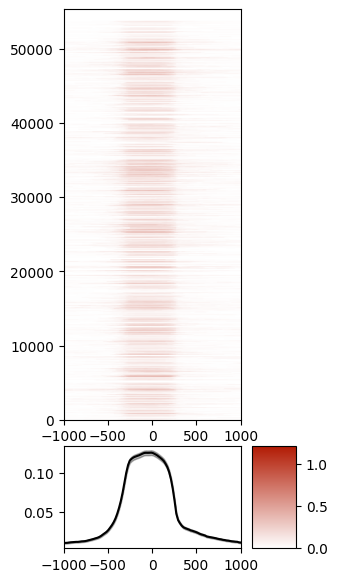

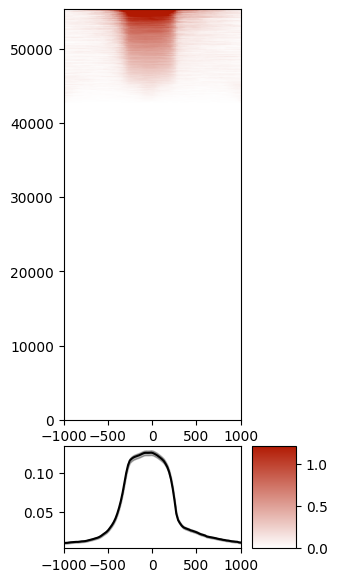

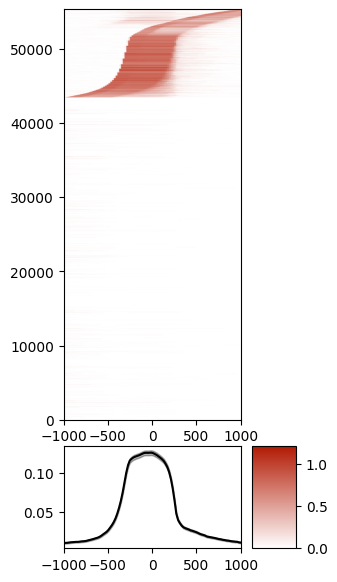

In [4]:
normalized_subtracted_values = Pyntegrate.SeqSignalAnalysis.value_array_simple(atac_signal)
x = np.linspace(-1000, 1000, bins)

fig = Pyntegrate.SeqSignalAnalysis.heatmap_no_sorted(signal_values=normalized_subtracted_values, xAxis=x)
fig = Pyntegrate.SeqSignalAnalysis.heatmap_sorted_by_meanValues(signal_values=normalized_subtracted_values, xAxis=x)
fig = Pyntegrate.SeqSignalAnalysis.heatmap_sorted_by_maxValueIndex(signal_values=normalized_subtracted_values, xAxis=x)

Estos mapas de calor se ven así debido a que varios valores de la señal valen 0. Por lo que, al no eliminarlos, existen muchos espacios en blanco. Esto, se podría quitar y existe una función para ello.

## Añadiendo RNA-seq para combinarlo con DNase-seq

Lo primero que se tiene que hacer es cargar los datos. Para ello, se están usando datos simulados para poder combinarlos bien con DNase-seq.
Una vez se tienen estos datos cargados, se tienen que reindexar para que coincidan los genes con DNase-seq. Para ello se usa la función reindex_to que tiene la propia clase de DEseq2 que es con la que se crea el objeto de RNA-seq

In [7]:
data = Pyntegrate.results_table.DEseq2Results('/home/jerry/Documentos/Python3.10/prueba/mosimData/test_RNA-seq_w_changes.csv')
data.data['gene_id'] = data.data['GeneID']
data.reindex_to(tsses, attribute='gene_id')
data.data['log2foldchange']

0        0.866733
1       -0.703603
2       -0.337740
3       -0.024796
4       -1.058834
           ...   
38288   -1.000000
38289   -0.404259
38290         NaN
38291   -1.584963
38292         NaN
Name: log2foldchange, Length: 38293, dtype: float64

Une vez se tienen cargados los datos de RNA-seq, se tendría que ver cuales son los genes coincidentes entre sí para que no existan problemas de tamaños de array a la hora de generar gráficas. O, lo que es lo mismo, para no comparar un gen de un tipo cuando ese gen no existe en el otro tipo.

Len signal 10794
Data type:  <class 'Pyntegrate.results_table.DEseq2Results'> 
 data filtered_type <class 'pandas.core.frame.DataFrame'>
Data lenght after filtered: 10794


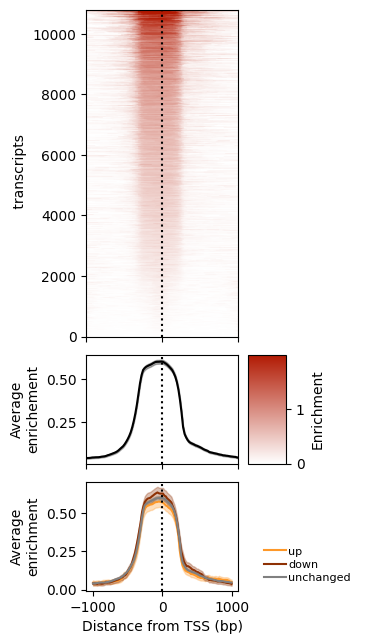

In [8]:
normalized_subtracted, data = Pyntegrate.SeqSignalAnalysis.chip_or_atac_genes_not_used_with_rna(data,
                                                                                                atac_signal,
                                                                                                id="id",
                                                                                                rna_column_name="GeneID",
                                                                                                delete_no_peaks=True)

# print(len(normalized_subtracted), len(data))


values = Pyntegrate.SeqSignalAnalysis.value_array_simple(normalized_subtracted)

fig = Pyntegrate.SeqSignalAnalysis.atac_or_chip_with_rna(signal_values=values, rna=data, xAxis=x)